Compare simulation with experiment

- In progress

________
Imports

In [1]:
import array
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict
import os

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal

import scipy.constants as const
from scipy.ndimage.filters import gaussian_filter

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

Useful functions

In [2]:
def _nan_helper(_arr):
    """
    Clean unwanted NaNs from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with NaNs

    Returns:
        nans, logical indices of NaNs
        index, a function with signature indices = index(logical_indices)
               to convert logical indices of NaNs to 'equivalent' indices

    Example:
        >>> nans, x = nan_helper(my_array)
        >>> my_array[nans] = np.interp(x(nans), x(~nans), my_array[~nans])
    """
    return np.isnan(_arr), lambda z: z.nonzero()[0]


def _array_cleaner(_arr, _ind):
    """
    Clean unwanted values from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with bad values
        _ind, precalculated indices of these bad values

    Returns:
        _arr, cleaned version of the input array

    Example:
        >>> indices = np.isnan(my_array)
        >>> my_array = array_cleaner(my_array, indices)
    """
    _arr[_ind] = np.nan
    nans, x = _nan_helper(_arr)
    _arr[nans] = np.interp(x(nans), x(~nans), _arr[~nans])
    return _arr


def _reshape_data(data):
    data = np.delete(data, 0, axis=1)
    data = np.delete(data, 1, axis=1)
    data = np.delete(data, 2, axis=1)
    data = np.delete(data, 3, axis=1)
    data = np.delete(data, -4, axis=1)
    data = np.delete(data, -3, axis=1)
    data = np.delete(data, -2, axis=1)
    data = np.delete(data, -1, axis=1)
    return data


def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

______
Initiate laser pulse fron the phase-intensity image pairs of a wavefront censor (WFS) diagnostic:

ccd_name = 'ccd_pump_off.txt'
* This file contains the photon count, perhaps normalized, which we loosely refer to as intensity.

wfs_name = 'wfs_pump_off.txt'
* This file contains the phase of the electric field.

In [3]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name_ei = 'ccd_pump_off.txt'
wfs_name_ei = 'wfs_pump_off.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file_ei = os.path.join(package_data_dir, ccd_name_ei)
wfs_path_to_file_ei = os.path.join(package_data_dir, wfs_name_ei)

# read the pixel size from the diagnostic metadata file
meta_file_name = 'wfs_meta.dat'
meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
with open(meta_path_to_file) as fh:
    for line in fh:
        if line.startswith("pixel_size_h_microns"):
            pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
        if line.startswith("pixel_size_v_microns"):
            pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

# central wavelength of the laser pulse
lambda0_micron = 0.8

# convert from microns to radians
rad_per_micron = math.pi / lambda0_micron

In [4]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data_exp_init = np.genfromtxt(wfs_path_to_file_ei, skip_header=1, skip_footer=0)

# clean up any NaN's
indices_ei = np.isnan(wfs_data_exp_init)
wfs_data_exp_init = _array_cleaner(wfs_data_exp_init, indices_ei)

# pad with zeros
wfs_temp_exp_init = np.pad(wfs_data_exp_init, 4, mode='constant')

# smooth the data
blur = 4
wfs_data_exp_init = gaussian_filter(wfs_temp_exp_init, sigma=blur)

wfs_data_exp_init *= rad_per_micron

# parse the intensity diagnostic data file
ccd_data_exp_init = np.genfromtxt(ccd_path_to_file_ei, skip_header=1)

# pad with zeros
ccd_temp_exp_init = np.pad(ccd_data_exp_init, 4, mode='constant')

# smooth the data
blur = 2
ccd_data_exp_init = gaussian_filter(ccd_temp_exp_init, sigma=blur)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data_exp_init) == np.shape(ccd_data_exp_init), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

In [5]:
# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x1_max_exp_init = 0.5 * (wfs_data_exp_init.shape[1] + 1.) * pixel_size_h * 1.0e-6    # [m] #* 1.0e-3    # [mm]
x1_min_exp_init = -x1_max_exp_init

y1_max_exp_init = 0.5 * (wfs_data_exp_init.shape[0] + 1.) * pixel_size_v * 1.0e-6    # [m] #* 1.0e-3    # [mm]
y1_min_exp_init = -y1_max_exp_init

In [6]:
# Construct the real and imaginary parts of the horizontal electric field
e_norm_exp_init = np.sqrt(ccd_data_exp_init)
ex_real_exp_init = np.multiply(e_norm_exp_init, np.cos(wfs_data_exp_init)).flatten(order='C')
ex_imag_exp_init = np.multiply(e_norm_exp_init, np.sin(wfs_data_exp_init)).flatten(order='C')

ex_numpy_exp_init = np.zeros(2*len(ex_real_exp_init))
for i in range(len(ex_real_exp_init)):
    ex_numpy_exp_init[2*i] = ex_real_exp_init[i]
    ex_numpy_exp_init[2*i+1] = ex_imag_exp_init[i]

ex_exp_init = array.array('f', ex_numpy_exp_init.tolist())

# Assume the vertical electric field is zero
ey_exp_init = array.array('f', len(ex_exp_init)*[0.])

In [7]:
# Create an SRW wavefront with the electric fields that we have inferred from the wave front sensor
wfr_exp_init = srwlib.SRWLWfr(_arEx=ex_exp_init, _arEy=ey_exp_init, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x1_min_exp_init, _xFin=x1_max_exp_init, _nx=np.shape(wfs_data_exp_init)[0], 
                    _yStart=y1_min_exp_init, _yFin=y1_max_exp_init, _ny=np.shape(wfs_data_exp_init)[1], 
                    _zStart=0., _partBeam=None)

x_exp_init=np.linspace(wfr_exp_init.mesh.xStart,wfr_exp_init.mesh.xFin,wfr_exp_init.mesh.nx)
y_exp_init=np.linspace(wfr_exp_init.mesh.yStart,wfr_exp_init.mesh.yFin,wfr_exp_init.mesh.ny)

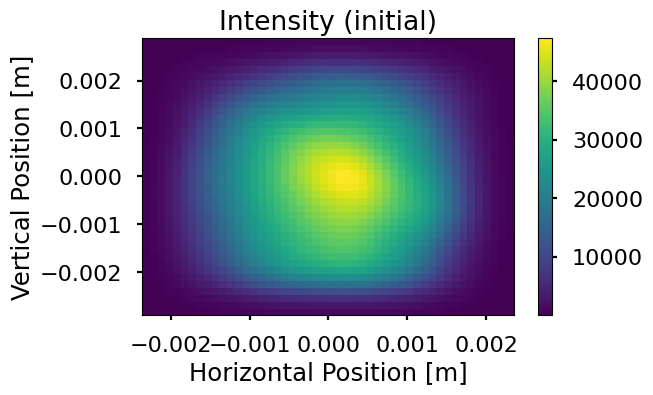

In [8]:
# Plot initial wavefront

intensity_exp_init = srwlib.array('f', [0]*wfr_exp_init.mesh.nx*wfr_exp_init.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity_exp_init, wfr_exp_init, 6, 0, 3, wfr_exp_init.mesh.eStart, 0, 0) # extracts intensity

# Reshaping data from flat to 2D array
intensity_2D_exp_init = np.array(intensity_exp_init).reshape((wfr_exp_init.mesh.nx, wfr_exp_init.mesh.ny), order='C')

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init, x_exp_init, intensity_2D_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [m]')#[mm]')
    ax.set_xlabel(r'Horizontal Position [m]')#[mm]')
    ax.set_title('Intensity (initial)')

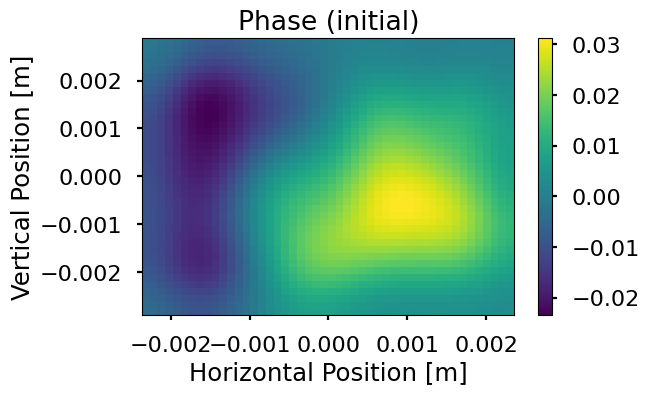

In [9]:
# initial phase
phase_exp_init = srwlib.array('d', [0]*wfr_exp_init.mesh.nx*wfr_exp_init.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_init, wfr_exp_init, 0, 4, 3, wfr_exp_init.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_exp_init = np.array(phase_exp_init).reshape((wfr_exp_init.mesh.nx, wfr_exp_init.mesh.ny), order='C')

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init, x_exp_init, phase_2d_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [m]')#[mm]')
    ax.set_ylabel(r'Vertical Position [m]')#[mm]')
    ax.set_title('Phase (initial)')

________
Create pulse

In [10]:
# create a laser pulse, using the wavefront created above

_LASER_PULSE = PKDict(
        nslice       = 1,
        chirp        = 0,
        photon_e_ev  = wfr_exp_init.mesh.eStart,
        num_sig_long = 3.,
        dist_waist   = 0.002,
        tau_fwhm     = 0.1 / const.c / math.sqrt(2.),
        pulseE       = 0.001,
        sigx_waist   = 0.000186, # 1.0e-3,
        sigy_waist   = 0.000186, # 1.0e-3,
)

# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr_exp_init
slice[0].n_photons_2d = slice[0].calc_init_n_photons() # Need to recalculate number of photons when updating the wavefront

_______
Initialize crystal

In [11]:
# _N_SLICE_DEFAULT = 50
# _N0_DEFAULT = 1.75
# _N2_DEFAULT = 0.001
# _CRYSTAL_DEFAULTS = PKDict(
#     n0=[_N0_DEFAULT for _ in range(_N_SLICE_DEFAULT)],
#     n2=[_N2_DEFAULT for _ in range(_N_SLICE_DEFAULT)],
#     length=0.2,
#     l_scale=1,
#     nslice=_N_SLICE_DEFAULT,
#     slice_index=0,
#     A = 9.99988571e-01,
#     B = 1.99999238e-01,
#     C = -1.14285279e-04,
#     D = 9.99988571e-01,
#     inversion_n_cells = 64,
#     inversion_mesh_extent = 0.01, # [m]
#     crystal_alpha   = 120.0,      # [1/m], 1.2 1/cm
#     pump_waist      = 0.00164,  # [m]
#     pump_wavelength = 532.0e-9, # [m]
#     pump_energy     = 0.0211,   # [J], pump laser energy onto the crystal
# )

num_slices = 5

crystal_params = PKDict(
        length      = 2.5/100.0, # [m]
        nslice      = num_slices,
        l_scale     = 0.1,
        n0          = [1.76 for _ in range(num_slices)],
        n2          = [0.1 for _ in range(num_slices)], #[16.0 for _ in range(num_slices)],
        pump_energy = 0.0 #0.0211,    # [J]
)

e_crystal = crystal.Crystal(crystal_params)

_________
Propagate through crystal once

In [12]:
#e_crystal = crystal.Crystal(crystal_params)
#nslices_crystal = len(e_crystal.slice)

#nslices_pulse = len(LP.slice)

#print('Total num excited states: ', np.sum(np.sum(e_crystal.slice[0].pop_inversion_mesh)))

#print('\nPropagating ', nslices_pulse, 'laser slices through ', nslices_crystal,' crystal slices')


prop_type = 'n0n2_srw' #'abcd_lct' #''n0n2_lct' #'n0n2_srw' #'gain_test'
LP = e_crystal.propagate(LP, prop_type)

wfr_sim_final=LP.slice[0].wfr

x_sim_final=np.linspace(wfr_sim_final.mesh.xStart,wfr_sim_final.mesh.xFin,wfr_sim_final.mesh.nx)
y_sim_final=np.linspace(wfr_sim_final.mesh.yStart,wfr_sim_final.mesh.yFin,wfr_sim_final.mesh.ny)

#print('Total num excited states: ', np.sum(np.sum(e_crystal.slice[0].pop_inversion_mesh)))

prop_type = n0n2_srw
n0: 1.76, n2: 0.1
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
n0: 1.76, n2: 0.1
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
n0: 1.76, n2: 0.1
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
n0: 1.76, n2: 0.1
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
n0: 1.76, n2: 0.1
Propagated pulse slice  1  of  1


______
Plot intensity and phase again

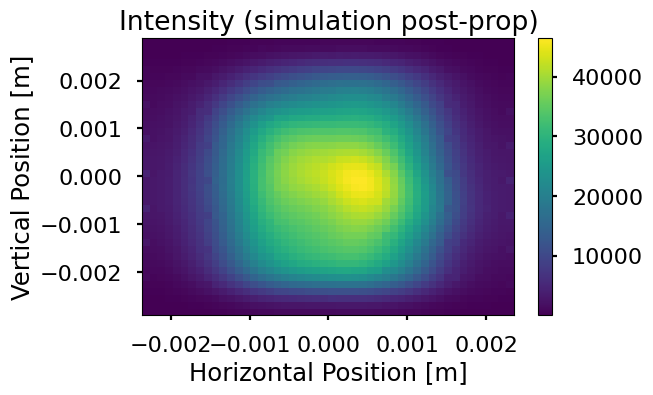

In [13]:
# transmitted pulse - intensity
intensity_sim_final = srwlib.array('f', [0]*wfr_sim_final.mesh.nx*wfr_sim_final.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity_sim_final, wfr_sim_final, 0, 0, 3, wfr_sim_final.mesh.eStart, 0, 0) #extracts intensity

# Reshaping data from flat to 2D array
intens_2d_sim_final = np.array(intensity_sim_final).reshape((wfr_sim_final.mesh.nx, wfr_sim_final.mesh.ny), order='C')

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final, x_sim_final, intens_2d_sim_final, cmap=plt.cm.viridis, shading='auto') #viridis
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [m]')
    ax.set_xlabel(r'Horizontal Position [m]')
    ax.set_title('Intensity (simulation post-prop)')


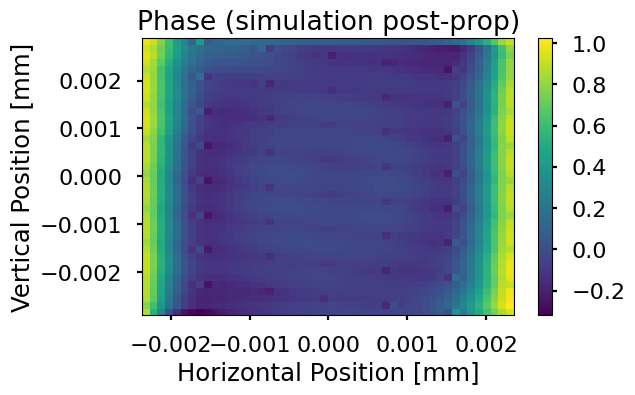

In [14]:
# transmitted pulse - phase
phase_sim_final = srwlib.array('d', [0]*wfr_sim_final.mesh.nx*wfr_sim_final.mesh.ny) # "flat" array to take 2D phase data
srwl.CalcIntFromElecField(phase_sim_final, wfr_sim_final, 0, 4, 3, wfr_sim_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping data from flat to 2D array
phase_2d_sim_final = np.array(phase_sim_final).reshape((wfr_sim_final.mesh.nx, wfr_sim_final.mesh.ny), order='C')

# ################
# # this is a hack to fix odd phase values...
# ################
# max_phase_allowed = 1.0e4
# if np.max(phase_2d_sim_final) >= max_phase_allowed:
#     indices = (np.where(phase_2d_sim_final >= max_phase_allowed))
#     phase_2d_sim_final = _array_cleaner(phase_2d_sim_final, indices)

# min_phase_allowed = -0.3e4
# if np.min(phase_2d_sim_final) <= min_phase_allowed:
#     indices = (np.where(phase_2d_sim_final <= min_phase_allowed))
#     phase_2d_sim_final = _array_cleaner(phase_2d_sim_final, indices)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final, x_sim_final, phase_2d_sim_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Phase (simulation post-prop)')

________
Plots from ccd/wfs peak timing data

In [15]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name_ef = 'ccd_peak_timing.txt'
wfs_name_ef = 'wfs_peak_timing.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file_ef = os.path.join(package_data_dir, ccd_name_ef)
wfs_path_to_file_ef = os.path.join(package_data_dir, wfs_name_ef)

# parse the wave front sensor (WFS) diagnostic data file
wfs_data_exp_final = np.genfromtxt(wfs_path_to_file_ef, skip_header=1, skip_footer=0)

# clean up any NaN's
indices_ef = np.isnan(wfs_data_exp_final)
wfs_data_exp_final = _array_cleaner(wfs_data_exp_final, indices_ef)

# pad with zeros
wfs_temp_exp_final = np.pad(wfs_data_exp_final, 4, mode='constant')

# smooth the data
blur = 4
wfs_data_exp_final = gaussian_filter(wfs_temp_exp_final, sigma=blur)

# convert from microns to radians
wfs_data_exp_final *= rad_per_micron

# parse the intensity diagnostic data file
ccd_data_from_txt_ef = np.genfromtxt(ccd_path_to_file_ef, skip_header=1)

# pad with zeros
ccd_temp_exp_final = np.pad(ccd_data_from_txt_ef, 4, mode='constant')

# smooth the data
blur = 2
ccd_data_exp_final = gaussian_filter(ccd_temp_exp_final, sigma=blur)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data_exp_final) == np.shape(ccd_data_exp_final), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x1_max_exp_final = 0.5 * (wfs_data_exp_final.shape[1] + 1.) * pixel_size_h * 1.0e-6    # [m] #* 1.0e-3    # [mm]
x1_min_exp_final = -x1_max_exp_final

y1_max_exp_final = 0.5 * (wfs_data_exp_final.shape[0] + 1.) * pixel_size_v * 1.0e-6    # [m] #* 1.0e-3    # [m]
y1_min_exp_final = -y1_max_exp_final

# Construct the real and imaginary parts of the horizontal electric field
e_norm_exp_final = np.sqrt(ccd_data_exp_final)
ex_real_exp_final = np.multiply(e_norm_exp_final, np.cos(wfs_data_exp_final)).flatten(order='C')
ex_imag_exp_final = np.multiply(e_norm_exp_final, np.sin(wfs_data_exp_final)).flatten(order='C')

ex_numpy_exp_final = np.zeros(2*len(ex_real_exp_final))
for i in range(len(ex_real_exp_final)):
    ex_numpy_exp_final[2*i] = ex_real_exp_final[i]
    ex_numpy_exp_final[2*i+1] = ex_imag_exp_final[i]

ex_exp_final = array.array('f', ex_numpy_exp_final.tolist())

# Assume the vertical electric field is zero
ey_exp_final = array.array('f', len(ex_exp_final)*[0.])

# Create an SRW wavefront with the electric fields that we have inferred from the wave front sensor
wfr_exp_final = srwlib.SRWLWfr(_arEx=ex_exp_final, _arEy=ey_exp_final, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x1_min_exp_final, _xFin=x1_max_exp_final, _nx=np.shape(wfs_data_exp_final)[0], 
                    _yStart=y1_min_exp_final, _yFin=y1_max_exp_final, _ny=np.shape(wfs_data_exp_final)[1], 
                    _zStart=0., _partBeam=None)

x_exp_final=np.linspace(wfr_exp_final.mesh.xStart,wfr_exp_final.mesh.xFin,wfr_exp_final.mesh.nx)
y_exp_final=np.linspace(wfr_exp_final.mesh.yStart,wfr_exp_final.mesh.yFin,wfr_exp_final.mesh.ny)

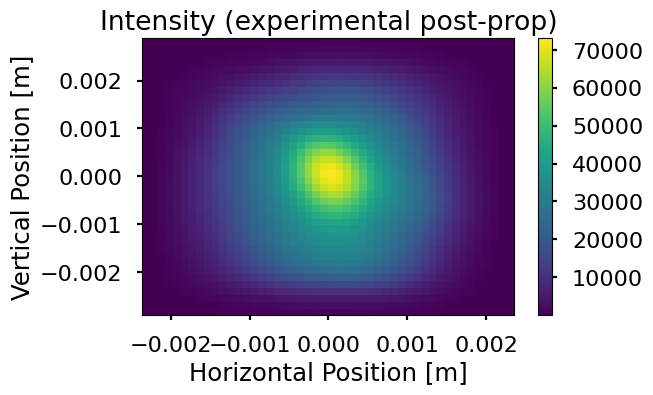

In [16]:
# Extract intensity from experimental post-prop wavefront
intensity_exp_final = srwlib.array('f', [0]*wfr_exp_final.mesh.nx*wfr_exp_final.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(intensity_exp_final, wfr_exp_final, 6, 0, 3, wfr_exp_final.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intensity_2D_exp_final = np.array(intensity_exp_final).reshape((wfr_exp_final.mesh.nx, wfr_exp_final.mesh.ny), order='C')

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final, x_exp_final, intensity_2D_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [m]')#[mm]')
    ax.set_xlabel(r'Horizontal Position [m]')#[mm]')
    ax.set_title('Intensity (experimental post-prop)')

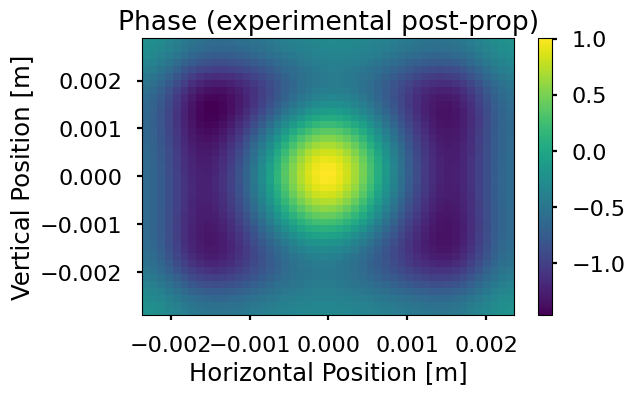

In [17]:
# Extract phase from experimental post-prop wavefront
phase_exp_final = srwlib.array('d', [0]*wfr_exp_final.mesh.nx*wfr_exp_final.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_final, wfr_exp_final, 0, 4, 3, wfr_exp_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping phase data from flat to 2D array
phase_2d_exp_final = np.array(phase_exp_final).reshape((wfr_exp_final.mesh.nx, wfr_exp_final.mesh.ny), order='C')

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final, x_exp_final, phase_2d_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [m]')#[mm]')
    ax.set_ylabel(r'Vertical Position [m]')#[mm]')
    ax.set_title('Phase (experimental post-prop)')